In [2]:
import numpy as np
from tifffile import imread, imsave
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import re
import random
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
def stitch_plane(seg_files, plane_index, tile_shape):
    """
    Stitch individual tiles into a single Z-plane.
    Assumes tile filenames are in the format 'seg__s00_Y0_X0.tif'.
    """
    print(f"Started stitching plane {plane_index}.")

    # Regular expression to extract Y and X coordinates
    coord_pattern = re.compile(r'_Y(\d+)_X(\d+)\.tif$')

    # Initialize an empty array for the full plane
    full_plane_dim_y = max(int(coord_pattern.search(f).group(1)) for f in seg_files) + 1
    full_plane_dim_x = max(int(coord_pattern.search(f).group(2)) for f in seg_files) + 1
    full_plane = np.zeros((full_plane_dim_y * tile_shape[0], full_plane_dim_x * tile_shape[1]), dtype=np.uint8)

    for file in seg_files:
        match = coord_pattern.search(file)
        if match:
            y, x = map(int, match.groups())
            print(f"Processing tile: {file}, Position: Y{y}, X{x}")

            try:
                tile = imread(file)
                full_plane[y * tile_shape[0]:(y + 1) * tile_shape[0], x * tile_shape[1]:(x + 1) * tile_shape[1]] = tile
            except FileNotFoundError:
                print(f"Warning: Tile {file} not found. Skipping this tile.")

    print(f"Finished stitching plane {plane_index}.")
    return full_plane


In [4]:
def analyze_connectivity(plane, plane_index, visualize=True):
    """
    Perform connectivity analysis and return bounding boxes of connected regions.
    """
    print(f"Starting connectivity analysis for plane {plane_index}...")

    stitched_normalized_plane = plane #/255
    threshold = 8 #threshold_otsu(stitched_normalized_plane)
    binary_plane = stitched_normalized_plane > threshold

    if visualize:
        # Display the raw stitched binary plane
        plt.figure(figsize=(10, 10))
        plt.imshow(binary_plane, cmap='gray')
        plt.title(f"Raw Stitched Binary Plane: {plane_index}")
        plt.show()

    # Perform connectivity analysis
    labeled_plane = label(binary_plane, connectivity=2, background=0)
    regions = regionprops(labeled_plane)

    bounding_boxes = [{'z_index': plane_index, 'bbox': region.bbox, 'area':region.area} for region in regions if region.area > 1000]
    
    print(f"Found {len(bounding_boxes)} regions in plane {plane_index}.")
    
    if visualize:
        # Display the labeled plane with bounding boxes
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(labeled_plane, cmap='nipy_spectral')
        for region in regions:
            if region.area > 0:
                minr, minc, maxr, maxc = region.bbox
                rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
        plt.title(f"Connectivity Analysis for Plane: {plane_index}")
        plt.show()

    return bounding_boxes

In [5]:
def calculate_center(bbox):
    """
    Calculate the center of the bounding box in 2D.
    """
    min_row, min_col, max_row, max_col = bbox
    center_row = ((max_row + min_row) // 2)
    center_col = ((max_col + min_col) // 2)
    return center_row, center_col

In [6]:
def main():
    print("Starting main process...")
    root_dir = 'D:/shared_drive/oz'
    seg_dir = os.path.join(root_dir, 'seg')
    tile_shape = (4096, 4096)
    output_file = os.path.join(root_dir, 'bounding_boxes.txt')
    visualize_slice = 's00'  # Add the slice you want to visualize here

    object_count = 0

    with open(output_file, 'w') as file:
        file.write("ID, Slice, Ymin, Xmin, Ymax, Xmax, VAST-CenterX, VAST-CenterX, VAST-Slice\n")

        z_planes = sorted(set(f.split('__')[1].split('_Y')[0] for f in os.listdir(seg_dir)))
        
        for z_index, z in enumerate(z_planes):
            print(f"Processing Z-plane {z}...")
            seg_files = glob.glob(os.path.join(seg_dir, f'seg__{z}_*.tif'))
            stitched_plane = stitch_plane(seg_files, z, tile_shape)

            visualize_current = (z == visualize_slice)
            bounding_boxes = analyze_connectivity(stitched_plane, z_index, visualize=visualize_current)

            print(f"Writing data for Z-plane {z}...")            
            
            # Print the number of objects found in the current Z-plane
            print(f"Number of objects found in Z-plane {z}: {len(bounding_boxes)}")
            
            for bbox_data in bounding_boxes:
                object_count += 1
                min_row, min_col, max_row, max_col = bbox_data['bbox']
                
                center_row, center_col = calculate_center(bbox_data['bbox'])
                file.write(f"{object_count}, {z_index}, {min_row}, {min_col}, {max_row}, {max_col}, {center_col}, {center_row}, {z_index}\n")
                
                # Flush the file buffer to write data immediately to disk
                file.flush()

Starting main process...
Processing Z-plane s00...
Started stitching plane s00.
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X0.tif, Position: Y0, X0
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X1.tif, Position: Y0, X1
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X10.tif, Position: Y0, X10
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X11.tif, Position: Y0, X11
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X12.tif, Position: Y0, X12
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X13.tif, Position: Y0, X13
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X14.tif, Position: Y0, X14
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X15.tif, Position: Y0, X15
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X16.tif, Position: Y0, X16
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X17.tif, Position: Y0, X17
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X18.tif, Position: Y0, X18
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y0_X19

Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X21.tif, Position: Y13, X21
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X22.tif, Position: Y13, X22
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X23.tif, Position: Y13, X23
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X3.tif, Position: Y13, X3
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X4.tif, Position: Y13, X4
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X5.tif, Position: Y13, X5
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X6.tif, Position: Y13, X6
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X7.tif, Position: Y13, X7
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X8.tif, Position: Y13, X8
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y13_X9.tif, Position: Y13, X9
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y14_X0.tif, Position: Y14, X0
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y14_X1.tif, Position: Y14, X1
Processing tile: D:/shared_drive/oz\seg\seg__s

Processing tile: D:/shared_drive/oz\seg\seg__s00_Y17_X9.tif, Position: Y17, X9
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X0.tif, Position: Y18, X0
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X1.tif, Position: Y18, X1
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X10.tif, Position: Y18, X10
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X11.tif, Position: Y18, X11
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X12.tif, Position: Y18, X12
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X13.tif, Position: Y18, X13
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X14.tif, Position: Y18, X14
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X15.tif, Position: Y18, X15
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X16.tif, Position: Y18, X16
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X17.tif, Position: Y18, X17
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y18_X18.tif, Position: Y18, X18
Processing tile: D:/shared_drive/o

Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X20.tif, Position: Y21, X20
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X21.tif, Position: Y21, X21
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X22.tif, Position: Y21, X22
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X23.tif, Position: Y21, X23
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X3.tif, Position: Y21, X3
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X4.tif, Position: Y21, X4
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X5.tif, Position: Y21, X5
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X6.tif, Position: Y21, X6
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X7.tif, Position: Y21, X7
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X8.tif, Position: Y21, X8
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y21_X9.tif, Position: Y21, X9
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y22_X0.tif, Position: Y22, X0
Processing tile: D:/shared_drive/oz\seg\seg_

Processing tile: D:/shared_drive/oz\seg\seg__s00_Y3_X8.tif, Position: Y3, X8
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y3_X9.tif, Position: Y3, X9
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X0.tif, Position: Y4, X0
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X1.tif, Position: Y4, X1
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X10.tif, Position: Y4, X10
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X11.tif, Position: Y4, X11
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X12.tif, Position: Y4, X12
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X13.tif, Position: Y4, X13
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X14.tif, Position: Y4, X14
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X15.tif, Position: Y4, X15
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X16.tif, Position: Y4, X16
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X17.tif, Position: Y4, X17
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y4_X18.tif,

Processing tile: D:/shared_drive/oz\seg\seg__s00_Y8_X22.tif, Position: Y8, X22
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y8_X23.tif, Position: Y8, X23
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y8_X3.tif, Position: Y8, X3
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y8_X4.tif, Position: Y8, X4
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y8_X5.tif, Position: Y8, X5
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y8_X6.tif, Position: Y8, X6
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y8_X7.tif, Position: Y8, X7
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y8_X8.tif, Position: Y8, X8
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y8_X9.tif, Position: Y8, X9
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y9_X0.tif, Position: Y9, X0
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y9_X1.tif, Position: Y9, X1
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y9_X10.tif, Position: Y9, X10
Processing tile: D:/shared_drive/oz\seg\seg__s00_Y9_X11.tif, Position:

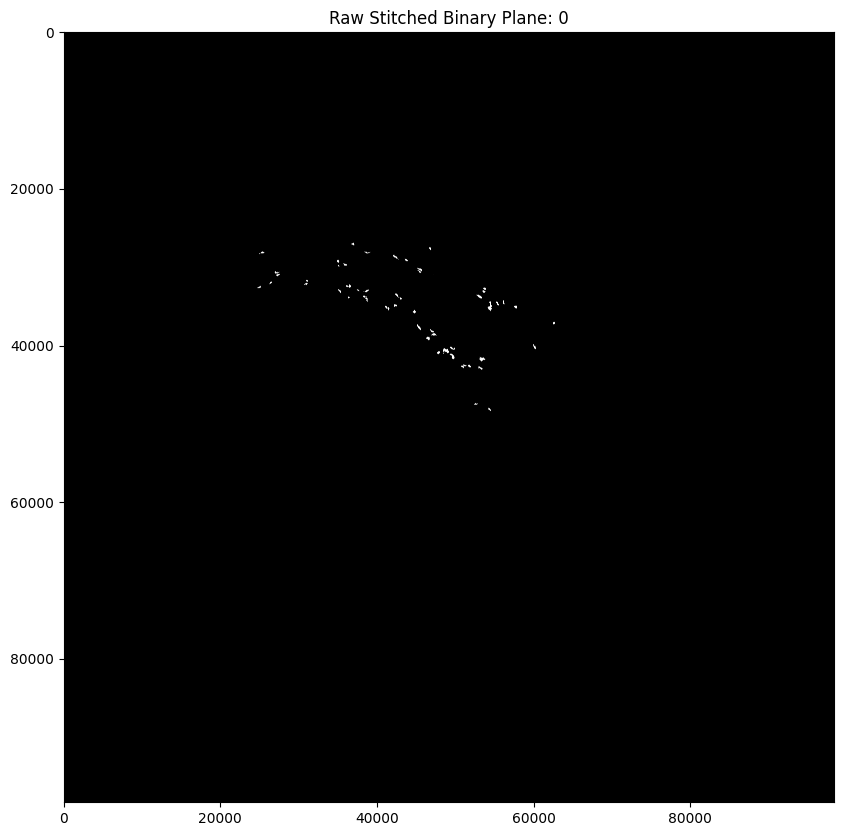

Found 55 regions in plane 0.


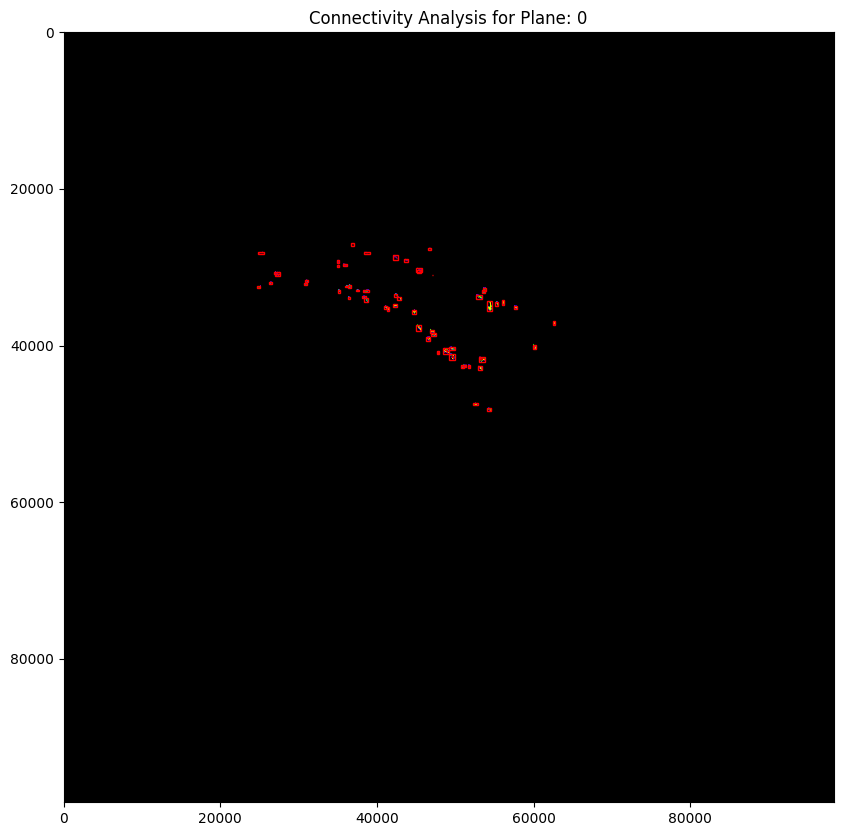

Writing data for Z-plane s00...
Number of objects found in Z-plane s00: 55
Processing Z-plane s01...
Started stitching plane s01.
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X0.tif, Position: Y0, X0
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X1.tif, Position: Y0, X1
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X10.tif, Position: Y0, X10
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X11.tif, Position: Y0, X11
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X12.tif, Position: Y0, X12
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X13.tif, Position: Y0, X13
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X14.tif, Position: Y0, X14
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X15.tif, Position: Y0, X15
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X16.tif, Position: Y0, X16
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X17.tif, Position: Y0, X17
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y0_X18.tif, Position: Y0, X18
Proce

Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X19.tif, Position: Y13, X19
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X2.tif, Position: Y13, X2
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X20.tif, Position: Y13, X20
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X21.tif, Position: Y13, X21
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X22.tif, Position: Y13, X22
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X23.tif, Position: Y13, X23
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X3.tif, Position: Y13, X3
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X4.tif, Position: Y13, X4
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X5.tif, Position: Y13, X5
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X6.tif, Position: Y13, X6
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X7.tif, Position: Y13, X7
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y13_X8.tif, Position: Y13, X8
Processing tile: D:/shared_drive/oz\seg\se

Processing tile: D:/shared_drive/oz\seg\seg__s01_Y17_X9.tif, Position: Y17, X9
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X0.tif, Position: Y18, X0
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X1.tif, Position: Y18, X1
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X10.tif, Position: Y18, X10
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X11.tif, Position: Y18, X11
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X12.tif, Position: Y18, X12
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X13.tif, Position: Y18, X13
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X14.tif, Position: Y18, X14
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X15.tif, Position: Y18, X15
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X16.tif, Position: Y18, X16
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X17.tif, Position: Y18, X17
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y18_X18.tif, Position: Y18, X18
Processing tile: D:/shared_drive/o

Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X19.tif, Position: Y21, X19
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X2.tif, Position: Y21, X2
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X20.tif, Position: Y21, X20
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X21.tif, Position: Y21, X21
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X22.tif, Position: Y21, X22
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X23.tif, Position: Y21, X23
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X3.tif, Position: Y21, X3
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X4.tif, Position: Y21, X4
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X5.tif, Position: Y21, X5
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X6.tif, Position: Y21, X6
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X7.tif, Position: Y21, X7
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y21_X8.tif, Position: Y21, X8
Processing tile: D:/shared_drive/oz\seg\se

Processing tile: D:/shared_drive/oz\seg\seg__s01_Y3_X6.tif, Position: Y3, X6
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y3_X7.tif, Position: Y3, X7
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y3_X8.tif, Position: Y3, X8
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y3_X9.tif, Position: Y3, X9
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y4_X0.tif, Position: Y4, X0
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y4_X1.tif, Position: Y4, X1
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y4_X10.tif, Position: Y4, X10
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y4_X11.tif, Position: Y4, X11
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y4_X12.tif, Position: Y4, X12
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y4_X13.tif, Position: Y4, X13
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y4_X14.tif, Position: Y4, X14
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y4_X15.tif, Position: Y4, X15
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y4_X16.tif, Pos

Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X14.tif, Position: Y8, X14
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X15.tif, Position: Y8, X15
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X16.tif, Position: Y8, X16
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X17.tif, Position: Y8, X17
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X18.tif, Position: Y8, X18
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X19.tif, Position: Y8, X19
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X2.tif, Position: Y8, X2
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X20.tif, Position: Y8, X20
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X21.tif, Position: Y8, X21
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X22.tif, Position: Y8, X22
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X23.tif, Position: Y8, X23
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X3.tif, Position: Y8, X3
Processing tile: D:/shared_drive/oz\seg\seg__s01_Y8_X4.t

Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X19.tif, Position: Y11, X19
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X2.tif, Position: Y11, X2
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X20.tif, Position: Y11, X20
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X21.tif, Position: Y11, X21
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X22.tif, Position: Y11, X22
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X23.tif, Position: Y11, X23
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X3.tif, Position: Y11, X3
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X4.tif, Position: Y11, X4
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X5.tif, Position: Y11, X5
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X6.tif, Position: Y11, X6
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X7.tif, Position: Y11, X7
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y11_X8.tif, Position: Y11, X8
Processing tile: D:/shared_drive/oz\seg\se

Processing tile: D:/shared_drive/oz\seg\seg__s02_Y15_X6.tif, Position: Y15, X6
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y15_X7.tif, Position: Y15, X7
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y15_X8.tif, Position: Y15, X8
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y15_X9.tif, Position: Y15, X9
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y16_X0.tif, Position: Y16, X0
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y16_X1.tif, Position: Y16, X1
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y16_X10.tif, Position: Y16, X10
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y16_X11.tif, Position: Y16, X11
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y16_X12.tif, Position: Y16, X12
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y16_X13.tif, Position: Y16, X13
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y16_X14.tif, Position: Y16, X14
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y16_X15.tif, Position: Y16, X15
Processing tile: D:/shared_drive/oz\seg\

Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X14.tif, Position: Y1, X14
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X15.tif, Position: Y1, X15
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X16.tif, Position: Y1, X16
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X17.tif, Position: Y1, X17
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X18.tif, Position: Y1, X18
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X19.tif, Position: Y1, X19
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X2.tif, Position: Y1, X2
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X20.tif, Position: Y1, X20
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X21.tif, Position: Y1, X21
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X22.tif, Position: Y1, X22
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X23.tif, Position: Y1, X23
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X3.tif, Position: Y1, X3
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y1_X4.t

Processing tile: D:/shared_drive/oz\seg\seg__s02_Y23_X22.tif, Position: Y23, X22
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y23_X23.tif, Position: Y23, X23
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y23_X3.tif, Position: Y23, X3
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y23_X4.tif, Position: Y23, X4
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y23_X5.tif, Position: Y23, X5
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y23_X6.tif, Position: Y23, X6
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y23_X7.tif, Position: Y23, X7
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y23_X8.tif, Position: Y23, X8
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y23_X9.tif, Position: Y23, X9
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y2_X0.tif, Position: Y2, X0
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y2_X1.tif, Position: Y2, X1
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y2_X10.tif, Position: Y2, X10
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y2_

Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X10.tif, Position: Y6, X10
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X11.tif, Position: Y6, X11
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X12.tif, Position: Y6, X12
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X13.tif, Position: Y6, X13
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X14.tif, Position: Y6, X14
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X15.tif, Position: Y6, X15
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X16.tif, Position: Y6, X16
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X17.tif, Position: Y6, X17
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X18.tif, Position: Y6, X18
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X19.tif, Position: Y6, X19
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X2.tif, Position: Y6, X2
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X20.tif, Position: Y6, X20
Processing tile: D:/shared_drive/oz\seg\seg__s02_Y6_X2

Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X19.tif, Position: Y0, X19
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X2.tif, Position: Y0, X2
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X20.tif, Position: Y0, X20
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X21.tif, Position: Y0, X21
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X22.tif, Position: Y0, X22
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X23.tif, Position: Y0, X23
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X3.tif, Position: Y0, X3
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X4.tif, Position: Y0, X4
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X5.tif, Position: Y0, X5
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X6.tif, Position: Y0, X6
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X7.tif, Position: Y0, X7
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X8.tif, Position: Y0, X8
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y0_X9.tif, Positi

Processing tile: D:/shared_drive/oz\seg\seg__s03_Y13_X5.tif, Position: Y13, X5
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y13_X6.tif, Position: Y13, X6
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y13_X7.tif, Position: Y13, X7
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y13_X8.tif, Position: Y13, X8
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y13_X9.tif, Position: Y13, X9
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y14_X0.tif, Position: Y14, X0
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y14_X1.tif, Position: Y14, X1
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y14_X10.tif, Position: Y14, X10
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y14_X11.tif, Position: Y14, X11
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y14_X12.tif, Position: Y14, X12
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y14_X13.tif, Position: Y14, X13
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y14_X14.tif, Position: Y14, X14
Processing tile: D:/shared_drive/oz\seg\se

Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X12.tif, Position: Y18, X12
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X13.tif, Position: Y18, X13
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X14.tif, Position: Y18, X14
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X15.tif, Position: Y18, X15
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X16.tif, Position: Y18, X16
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X17.tif, Position: Y18, X17
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X18.tif, Position: Y18, X18
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X19.tif, Position: Y18, X19
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X2.tif, Position: Y18, X2
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X20.tif, Position: Y18, X20
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X21.tif, Position: Y18, X21
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y18_X22.tif, Position: Y18, X22
Processing tile: D:/shared_dri

Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X2.tif, Position: Y21, X2
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X20.tif, Position: Y21, X20
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X21.tif, Position: Y21, X21
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X22.tif, Position: Y21, X22
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X23.tif, Position: Y21, X23
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X3.tif, Position: Y21, X3
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X4.tif, Position: Y21, X4
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X5.tif, Position: Y21, X5
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X6.tif, Position: Y21, X6
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X7.tif, Position: Y21, X7
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X8.tif, Position: Y21, X8
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y21_X9.tif, Position: Y21, X9
Processing tile: D:/shared_drive/oz\seg\seg_

Processing tile: D:/shared_drive/oz\seg\seg__s03_Y3_X8.tif, Position: Y3, X8
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y3_X9.tif, Position: Y3, X9
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X0.tif, Position: Y4, X0
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X1.tif, Position: Y4, X1
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X10.tif, Position: Y4, X10
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X11.tif, Position: Y4, X11
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X12.tif, Position: Y4, X12
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X13.tif, Position: Y4, X13
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X14.tif, Position: Y4, X14
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X15.tif, Position: Y4, X15
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X16.tif, Position: Y4, X16
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X17.tif, Position: Y4, X17
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y4_X18.tif,

Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X20.tif, Position: Y8, X20
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X21.tif, Position: Y8, X21
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X22.tif, Position: Y8, X22
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X23.tif, Position: Y8, X23
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X3.tif, Position: Y8, X3
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X4.tif, Position: Y8, X4
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X5.tif, Position: Y8, X5
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X6.tif, Position: Y8, X6
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X7.tif, Position: Y8, X7
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X8.tif, Position: Y8, X8
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y8_X9.tif, Position: Y8, X9
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y9_X0.tif, Position: Y9, X0
Processing tile: D:/shared_drive/oz\seg\seg__s03_Y9_X1.tif, Position

Processing tile: D:/shared_drive/oz\seg\seg__s04_Y11_X6.tif, Position: Y11, X6
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y11_X7.tif, Position: Y11, X7
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y11_X8.tif, Position: Y11, X8
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y11_X9.tif, Position: Y11, X9
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y12_X0.tif, Position: Y12, X0
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y12_X1.tif, Position: Y12, X1
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y12_X10.tif, Position: Y12, X10
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y12_X11.tif, Position: Y12, X11
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y12_X12.tif, Position: Y12, X12
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y12_X13.tif, Position: Y12, X13
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y12_X14.tif, Position: Y12, X14
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y12_X15.tif, Position: Y12, X15
Processing tile: D:/shared_drive/oz\seg\

Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X13.tif, Position: Y16, X13
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X14.tif, Position: Y16, X14
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X15.tif, Position: Y16, X15
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X16.tif, Position: Y16, X16
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X17.tif, Position: Y16, X17
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X18.tif, Position: Y16, X18
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X19.tif, Position: Y16, X19
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X2.tif, Position: Y16, X2
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X20.tif, Position: Y16, X20
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X21.tif, Position: Y16, X21
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X22.tif, Position: Y16, X22
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y16_X23.tif, Position: Y16, X23
Processing tile: D:/shared_dri

Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X21.tif, Position: Y1, X21
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X22.tif, Position: Y1, X22
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X23.tif, Position: Y1, X23
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X3.tif, Position: Y1, X3
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X4.tif, Position: Y1, X4
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X5.tif, Position: Y1, X5
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X6.tif, Position: Y1, X6
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X7.tif, Position: Y1, X7
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X8.tif, Position: Y1, X8
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y1_X9.tif, Position: Y1, X9
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y20_X0.tif, Position: Y20, X0
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y20_X1.tif, Position: Y20, X1
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y20_X10.tif, Posi

Processing tile: D:/shared_drive/oz\seg\seg__s04_Y23_X7.tif, Position: Y23, X7
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y23_X8.tif, Position: Y23, X8
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y23_X9.tif, Position: Y23, X9
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X0.tif, Position: Y2, X0
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X1.tif, Position: Y2, X1
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X10.tif, Position: Y2, X10
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X11.tif, Position: Y2, X11
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X12.tif, Position: Y2, X12
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X13.tif, Position: Y2, X13
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X14.tif, Position: Y2, X14
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X15.tif, Position: Y2, X15
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X16.tif, Position: Y2, X16
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y2_X17.

Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X2.tif, Position: Y6, X2
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X20.tif, Position: Y6, X20
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X21.tif, Position: Y6, X21
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X22.tif, Position: Y6, X22
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X23.tif, Position: Y6, X23
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X3.tif, Position: Y6, X3
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X4.tif, Position: Y6, X4
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X5.tif, Position: Y6, X5
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X6.tif, Position: Y6, X6
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X7.tif, Position: Y6, X7
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X8.tif, Position: Y6, X8
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y6_X9.tif, Position: Y6, X9
Processing tile: D:/shared_drive/oz\seg\seg__s04_Y7_X0.tif, Position

Processing tile: D:/shared_drive/oz\seg\seg__s05_Y0_X7.tif, Position: Y0, X7
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y0_X8.tif, Position: Y0, X8
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y0_X9.tif, Position: Y0, X9
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y10_X0.tif, Position: Y10, X0
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y10_X1.tif, Position: Y10, X1
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y10_X10.tif, Position: Y10, X10
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y10_X11.tif, Position: Y10, X11
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y10_X12.tif, Position: Y10, X12
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y10_X13.tif, Position: Y10, X13
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y10_X14.tif, Position: Y10, X14
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y10_X15.tif, Position: Y10, X15
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y10_X16.tif, Position: Y10, X16
Processing tile: D:/shared_drive/oz\seg\seg_

Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X13.tif, Position: Y14, X13
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X14.tif, Position: Y14, X14
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X15.tif, Position: Y14, X15
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X16.tif, Position: Y14, X16
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X17.tif, Position: Y14, X17
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X18.tif, Position: Y14, X18
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X19.tif, Position: Y14, X19
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X2.tif, Position: Y14, X2
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X20.tif, Position: Y14, X20
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X21.tif, Position: Y14, X21
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X22.tif, Position: Y14, X22
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y14_X23.tif, Position: Y14, X23
Processing tile: D:/shared_dri

Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X21.tif, Position: Y18, X21
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X22.tif, Position: Y18, X22
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X23.tif, Position: Y18, X23
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X3.tif, Position: Y18, X3
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X4.tif, Position: Y18, X4
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X5.tif, Position: Y18, X5
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X6.tif, Position: Y18, X6
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X7.tif, Position: Y18, X7
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X8.tif, Position: Y18, X8
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y18_X9.tif, Position: Y18, X9
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y19_X0.tif, Position: Y19, X0
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y19_X1.tif, Position: Y19, X1
Processing tile: D:/shared_drive/oz\seg\seg__s

Processing tile: D:/shared_drive/oz\seg\seg__s05_Y21_X8.tif, Position: Y21, X8
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y21_X9.tif, Position: Y21, X9
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X0.tif, Position: Y22, X0
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X1.tif, Position: Y22, X1
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X10.tif, Position: Y22, X10
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X11.tif, Position: Y22, X11
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X12.tif, Position: Y22, X12
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X13.tif, Position: Y22, X13
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X14.tif, Position: Y22, X14
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X15.tif, Position: Y22, X15
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X16.tif, Position: Y22, X16
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y22_X17.tif, Position: Y22, X17
Processing tile: D:/shared_drive/oz\

Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X16.tif, Position: Y4, X16
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X17.tif, Position: Y4, X17
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X18.tif, Position: Y4, X18
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X19.tif, Position: Y4, X19
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X2.tif, Position: Y4, X2
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X20.tif, Position: Y4, X20
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X21.tif, Position: Y4, X21
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X22.tif, Position: Y4, X22
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X23.tif, Position: Y4, X23
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X3.tif, Position: Y4, X3
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X4.tif, Position: Y4, X4
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X5.tif, Position: Y4, X5
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y4_X6.tif, 

Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X0.tif, Position: Y9, X0
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X1.tif, Position: Y9, X1
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X10.tif, Position: Y9, X10
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X11.tif, Position: Y9, X11
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X12.tif, Position: Y9, X12
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X13.tif, Position: Y9, X13
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X14.tif, Position: Y9, X14
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X15.tif, Position: Y9, X15
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X16.tif, Position: Y9, X16
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X17.tif, Position: Y9, X17
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X18.tif, Position: Y9, X18
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X19.tif, Position: Y9, X19
Processing tile: D:/shared_drive/oz\seg\seg__s05_Y9_X2.t

Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X15.tif, Position: Y12, X15
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X16.tif, Position: Y12, X16
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X17.tif, Position: Y12, X17
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X18.tif, Position: Y12, X18
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X19.tif, Position: Y12, X19
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X2.tif, Position: Y12, X2
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X20.tif, Position: Y12, X20
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X21.tif, Position: Y12, X21
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X22.tif, Position: Y12, X22
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X23.tif, Position: Y12, X23
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X3.tif, Position: Y12, X3
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y12_X4.tif, Position: Y12, X4
Processing tile: D:/shared_drive/o

Processing tile: D:/shared_drive/oz\seg\seg__s06_Y16_X23.tif, Position: Y16, X23
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y16_X3.tif, Position: Y16, X3
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y16_X4.tif, Position: Y16, X4
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y16_X5.tif, Position: Y16, X5
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y16_X6.tif, Position: Y16, X6
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y16_X7.tif, Position: Y16, X7
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y16_X8.tif, Position: Y16, X8
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y16_X9.tif, Position: Y16, X9
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y17_X0.tif, Position: Y17, X0
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y17_X1.tif, Position: Y17, X1
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y17_X10.tif, Position: Y17, X10
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y17_X11.tif, Position: Y17, X11
Processing tile: D:/shared_drive/oz\seg\seg__s

Processing tile: D:/shared_drive/oz\seg\seg__s06_Y1_X9.tif, Position: Y1, X9
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X0.tif, Position: Y20, X0
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X1.tif, Position: Y20, X1
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X10.tif, Position: Y20, X10
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X11.tif, Position: Y20, X11
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X12.tif, Position: Y20, X12
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X13.tif, Position: Y20, X13
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X14.tif, Position: Y20, X14
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X15.tif, Position: Y20, X15
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X16.tif, Position: Y20, X16
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X17.tif, Position: Y20, X17
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y20_X18.tif, Position: Y20, X18
Processing tile: D:/shared_drive/oz\

Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X16.tif, Position: Y2, X16
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X17.tif, Position: Y2, X17
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X18.tif, Position: Y2, X18
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X19.tif, Position: Y2, X19
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X2.tif, Position: Y2, X2
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X20.tif, Position: Y2, X20
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X21.tif, Position: Y2, X21
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X22.tif, Position: Y2, X22
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X23.tif, Position: Y2, X23
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X3.tif, Position: Y2, X3
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X4.tif, Position: Y2, X4
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X5.tif, Position: Y2, X5
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y2_X6.tif, 

Processing tile: D:/shared_drive/oz\seg\seg__s06_Y6_X8.tif, Position: Y6, X8
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y6_X9.tif, Position: Y6, X9
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X0.tif, Position: Y7, X0
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X1.tif, Position: Y7, X1
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X10.tif, Position: Y7, X10
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X11.tif, Position: Y7, X11
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X12.tif, Position: Y7, X12
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X13.tif, Position: Y7, X13
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X14.tif, Position: Y7, X14
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X15.tif, Position: Y7, X15
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X16.tif, Position: Y7, X16
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X17.tif, Position: Y7, X17
Processing tile: D:/shared_drive/oz\seg\seg__s06_Y7_X18.tif,

Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X15.tif, Position: Y10, X15
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X16.tif, Position: Y10, X16
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X17.tif, Position: Y10, X17
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X18.tif, Position: Y10, X18
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X19.tif, Position: Y10, X19
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X2.tif, Position: Y10, X2
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X20.tif, Position: Y10, X20
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X21.tif, Position: Y10, X21
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X22.tif, Position: Y10, X22
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X23.tif, Position: Y10, X23
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X3.tif, Position: Y10, X3
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y10_X4.tif, Position: Y10, X4
Processing tile: D:/shared_drive/o

Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X21.tif, Position: Y14, X21
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X22.tif, Position: Y14, X22
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X23.tif, Position: Y14, X23
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X3.tif, Position: Y14, X3
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X4.tif, Position: Y14, X4
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X5.tif, Position: Y14, X5
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X6.tif, Position: Y14, X6
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X7.tif, Position: Y14, X7
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X8.tif, Position: Y14, X8
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y14_X9.tif, Position: Y14, X9
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y15_X0.tif, Position: Y15, X0
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y15_X1.tif, Position: Y15, X1
Processing tile: D:/shared_drive/oz\seg\seg__s

Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X1.tif, Position: Y19, X1
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X10.tif, Position: Y19, X10
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X11.tif, Position: Y19, X11
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X12.tif, Position: Y19, X12
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X13.tif, Position: Y19, X13
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X14.tif, Position: Y19, X14
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X15.tif, Position: Y19, X15
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X16.tif, Position: Y19, X16
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X17.tif, Position: Y19, X17
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X18.tif, Position: Y19, X18
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X19.tif, Position: Y19, X19
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y19_X2.tif, Position: Y19, X2
Processing tile: D:/shared_drive

Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X17.tif, Position: Y22, X17
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X18.tif, Position: Y22, X18
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X19.tif, Position: Y22, X19
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X2.tif, Position: Y22, X2
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X20.tif, Position: Y22, X20
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X21.tif, Position: Y22, X21
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X22.tif, Position: Y22, X22
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X23.tif, Position: Y22, X23
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X3.tif, Position: Y22, X3
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X4.tif, Position: Y22, X4
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X5.tif, Position: Y22, X5
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y22_X6.tif, Position: Y22, X6
Processing tile: D:/shared_drive/oz\se

Processing tile: D:/shared_drive/oz\seg\seg__s07_Y4_X6.tif, Position: Y4, X6
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y4_X7.tif, Position: Y4, X7
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y4_X8.tif, Position: Y4, X8
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y4_X9.tif, Position: Y4, X9
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y5_X0.tif, Position: Y5, X0
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y5_X1.tif, Position: Y5, X1
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y5_X10.tif, Position: Y5, X10
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y5_X11.tif, Position: Y5, X11
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y5_X12.tif, Position: Y5, X12
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y5_X13.tif, Position: Y5, X13
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y5_X14.tif, Position: Y5, X14
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y5_X15.tif, Position: Y5, X15
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y5_X16.tif, Pos

Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X13.tif, Position: Y9, X13
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X14.tif, Position: Y9, X14
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X15.tif, Position: Y9, X15
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X16.tif, Position: Y9, X16
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X17.tif, Position: Y9, X17
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X18.tif, Position: Y9, X18
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X19.tif, Position: Y9, X19
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X2.tif, Position: Y9, X2
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X20.tif, Position: Y9, X20
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X21.tif, Position: Y9, X21
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X22.tif, Position: Y9, X22
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X23.tif, Position: Y9, X23
Processing tile: D:/shared_drive/oz\seg\seg__s07_Y9_X3

Processing tile: D:/shared_drive/oz\seg\seg__s08_Y12_X22.tif, Position: Y12, X22
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y12_X23.tif, Position: Y12, X23
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y12_X3.tif, Position: Y12, X3
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y12_X4.tif, Position: Y12, X4
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y12_X5.tif, Position: Y12, X5
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y12_X6.tif, Position: Y12, X6
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y12_X7.tif, Position: Y12, X7
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y12_X8.tif, Position: Y12, X8
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y12_X9.tif, Position: Y12, X9
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y13_X0.tif, Position: Y13, X0
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y13_X1.tif, Position: Y13, X1
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y13_X10.tif, Position: Y13, X10
Processing tile: D:/shared_drive/oz\seg\seg__s

Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X0.tif, Position: Y17, X0
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X1.tif, Position: Y17, X1
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X10.tif, Position: Y17, X10
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X11.tif, Position: Y17, X11
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X12.tif, Position: Y17, X12
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X13.tif, Position: Y17, X13
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X14.tif, Position: Y17, X14
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X15.tif, Position: Y17, X15
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X16.tif, Position: Y17, X16
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X17.tif, Position: Y17, X17
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X18.tif, Position: Y17, X18
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y17_X19.tif, Position: Y17, X19
Processing tile: D:/shared_drive

Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X15.tif, Position: Y20, X15
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X16.tif, Position: Y20, X16
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X17.tif, Position: Y20, X17
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X18.tif, Position: Y20, X18
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X19.tif, Position: Y20, X19
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X2.tif, Position: Y20, X2
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X20.tif, Position: Y20, X20
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X21.tif, Position: Y20, X21
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X22.tif, Position: Y20, X22
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X23.tif, Position: Y20, X23
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X3.tif, Position: Y20, X3
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y20_X4.tif, Position: Y20, X4
Processing tile: D:/shared_drive/o

Processing tile: D:/shared_drive/oz\seg\seg__s08_Y2_X4.tif, Position: Y2, X4
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y2_X5.tif, Position: Y2, X5
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y2_X6.tif, Position: Y2, X6
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y2_X7.tif, Position: Y2, X7
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y2_X8.tif, Position: Y2, X8
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y2_X9.tif, Position: Y2, X9
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y3_X0.tif, Position: Y3, X0
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y3_X1.tif, Position: Y3, X1
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y3_X10.tif, Position: Y3, X10
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y3_X11.tif, Position: Y3, X11
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y3_X12.tif, Position: Y3, X12
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y3_X13.tif, Position: Y3, X13
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y3_X14.tif, Positio

Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X15.tif, Position: Y7, X15
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X16.tif, Position: Y7, X16
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X17.tif, Position: Y7, X17
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X18.tif, Position: Y7, X18
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X19.tif, Position: Y7, X19
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X2.tif, Position: Y7, X2
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X20.tif, Position: Y7, X20
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X21.tif, Position: Y7, X21
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X22.tif, Position: Y7, X22
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X23.tif, Position: Y7, X23
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X3.tif, Position: Y7, X3
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X4.tif, Position: Y7, X4
Processing tile: D:/shared_drive/oz\seg\seg__s08_Y7_X5.tif

Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X20.tif, Position: Y10, X20
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X21.tif, Position: Y10, X21
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X22.tif, Position: Y10, X22
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X23.tif, Position: Y10, X23
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X3.tif, Position: Y10, X3
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X4.tif, Position: Y10, X4
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X5.tif, Position: Y10, X5
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X6.tif, Position: Y10, X6
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X7.tif, Position: Y10, X7
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X8.tif, Position: Y10, X8
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y10_X9.tif, Position: Y10, X9
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y11_X0.tif, Position: Y11, X0
Processing tile: D:/shared_drive/oz\seg\seg_

Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X0.tif, Position: Y15, X0
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X1.tif, Position: Y15, X1
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X10.tif, Position: Y15, X10
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X11.tif, Position: Y15, X11
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X12.tif, Position: Y15, X12
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X13.tif, Position: Y15, X13
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X14.tif, Position: Y15, X14
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X15.tif, Position: Y15, X15
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X16.tif, Position: Y15, X16
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X17.tif, Position: Y15, X17
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X18.tif, Position: Y15, X18
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y15_X19.tif, Position: Y15, X19
Processing tile: D:/shared_drive

Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X17.tif, Position: Y19, X17
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X18.tif, Position: Y19, X18
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X19.tif, Position: Y19, X19
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X2.tif, Position: Y19, X2
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X20.tif, Position: Y19, X20
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X21.tif, Position: Y19, X21
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X22.tif, Position: Y19, X22
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X23.tif, Position: Y19, X23
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X3.tif, Position: Y19, X3
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X4.tif, Position: Y19, X4
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X5.tif, Position: Y19, X5
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y19_X6.tif, Position: Y19, X6
Processing tile: D:/shared_drive/oz\se

Processing tile: D:/shared_drive/oz\seg\seg__s09_Y22_X3.tif, Position: Y22, X3
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y22_X4.tif, Position: Y22, X4
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y22_X5.tif, Position: Y22, X5
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y22_X6.tif, Position: Y22, X6
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y22_X7.tif, Position: Y22, X7
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y22_X8.tif, Position: Y22, X8
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y22_X9.tif, Position: Y22, X9
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y23_X0.tif, Position: Y23, X0
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y23_X1.tif, Position: Y23, X1
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y23_X10.tif, Position: Y23, X10
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y23_X11.tif, Position: Y23, X11
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y23_X12.tif, Position: Y23, X12
Processing tile: D:/shared_drive/oz\seg\seg__s

Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X11.tif, Position: Y5, X11
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X12.tif, Position: Y5, X12
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X13.tif, Position: Y5, X13
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X14.tif, Position: Y5, X14
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X15.tif, Position: Y5, X15
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X16.tif, Position: Y5, X16
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X17.tif, Position: Y5, X17
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X18.tif, Position: Y5, X18
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X19.tif, Position: Y5, X19
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X2.tif, Position: Y5, X2
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X20.tif, Position: Y5, X20
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X21.tif, Position: Y5, X21
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y5_X2

Processing tile: D:/shared_drive/oz\seg\seg__s09_Y9_X22.tif, Position: Y9, X22
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y9_X23.tif, Position: Y9, X23
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y9_X3.tif, Position: Y9, X3
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y9_X4.tif, Position: Y9, X4
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y9_X5.tif, Position: Y9, X5
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y9_X6.tif, Position: Y9, X6
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y9_X7.tif, Position: Y9, X7
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y9_X8.tif, Position: Y9, X8
Processing tile: D:/shared_drive/oz\seg\seg__s09_Y9_X9.tif, Position: Y9, X9
Finished stitching plane s09.
Starting connectivity analysis for plane 9...
Found 30 regions in plane 9.
Writing data for Z-plane s09...
Number of objects found in Z-plane s09: 30
Processing Z-plane s10...
Started stitching plane s10.
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y0_X0.tif, Position

Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X1.tif, Position: Y13, X1
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X10.tif, Position: Y13, X10
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X11.tif, Position: Y13, X11
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X12.tif, Position: Y13, X12
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X13.tif, Position: Y13, X13
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X14.tif, Position: Y13, X14
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X15.tif, Position: Y13, X15
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X16.tif, Position: Y13, X16
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X17.tif, Position: Y13, X17
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X18.tif, Position: Y13, X18
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X19.tif, Position: Y13, X19
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y13_X2.tif, Position: Y13, X2
Processing tile: D:/shared_drive

Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X19.tif, Position: Y17, X19
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X2.tif, Position: Y17, X2
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X20.tif, Position: Y17, X20
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X21.tif, Position: Y17, X21
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X22.tif, Position: Y17, X22
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X23.tif, Position: Y17, X23
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X3.tif, Position: Y17, X3
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X4.tif, Position: Y17, X4
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X5.tif, Position: Y17, X5
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X6.tif, Position: Y17, X6
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X7.tif, Position: Y17, X7
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y17_X8.tif, Position: Y17, X8
Processing tile: D:/shared_drive/oz\seg\se

Processing tile: D:/shared_drive/oz\seg\seg__s10_Y20_X4.tif, Position: Y20, X4
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y20_X5.tif, Position: Y20, X5
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y20_X6.tif, Position: Y20, X6
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y20_X7.tif, Position: Y20, X7
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y20_X8.tif, Position: Y20, X8
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y20_X9.tif, Position: Y20, X9
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y21_X0.tif, Position: Y21, X0
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y21_X1.tif, Position: Y21, X1
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y21_X10.tif, Position: Y21, X10
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y21_X11.tif, Position: Y21, X11
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y21_X12.tif, Position: Y21, X12
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y21_X13.tif, Position: Y21, X13
Processing tile: D:/shared_drive/oz\seg\seg_

Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X12.tif, Position: Y3, X12
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X13.tif, Position: Y3, X13
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X14.tif, Position: Y3, X14
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X15.tif, Position: Y3, X15
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X16.tif, Position: Y3, X16
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X17.tif, Position: Y3, X17
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X18.tif, Position: Y3, X18
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X19.tif, Position: Y3, X19
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X2.tif, Position: Y3, X2
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X20.tif, Position: Y3, X20
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X21.tif, Position: Y3, X21
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X22.tif, Position: Y3, X22
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y3_X2

Processing tile: D:/shared_drive/oz\seg\seg__s10_Y7_X23.tif, Position: Y7, X23
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y7_X3.tif, Position: Y7, X3
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y7_X4.tif, Position: Y7, X4
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y7_X5.tif, Position: Y7, X5
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y7_X6.tif, Position: Y7, X6
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y7_X7.tif, Position: Y7, X7
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y7_X8.tif, Position: Y7, X8
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y7_X9.tif, Position: Y7, X9
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y8_X0.tif, Position: Y8, X0
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y8_X1.tif, Position: Y8, X1
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y8_X10.tif, Position: Y8, X10
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y8_X11.tif, Position: Y8, X11
Processing tile: D:/shared_drive/oz\seg\seg__s10_Y8_X12.tif, Position:

Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X1.tif, Position: Y11, X1
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X10.tif, Position: Y11, X10
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X11.tif, Position: Y11, X11
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X12.tif, Position: Y11, X12
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X13.tif, Position: Y11, X13
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X14.tif, Position: Y11, X14
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X15.tif, Position: Y11, X15
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X16.tif, Position: Y11, X16
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X17.tif, Position: Y11, X17
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X18.tif, Position: Y11, X18
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X19.tif, Position: Y11, X19
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y11_X2.tif, Position: Y11, X2
Processing tile: D:/shared_drive

Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X17.tif, Position: Y15, X17
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X18.tif, Position: Y15, X18
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X19.tif, Position: Y15, X19
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X2.tif, Position: Y15, X2
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X20.tif, Position: Y15, X20
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X21.tif, Position: Y15, X21
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X22.tif, Position: Y15, X22
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X23.tif, Position: Y15, X23
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X3.tif, Position: Y15, X3
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X4.tif, Position: Y15, X4
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X5.tif, Position: Y15, X5
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y15_X6.tif, Position: Y15, X6
Processing tile: D:/shared_drive/oz\se

Processing tile: D:/shared_drive/oz\seg\seg__s11_Y19_X6.tif, Position: Y19, X6
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y19_X7.tif, Position: Y19, X7
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y19_X8.tif, Position: Y19, X8
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y19_X9.tif, Position: Y19, X9
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y1_X0.tif, Position: Y1, X0
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y1_X1.tif, Position: Y1, X1
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y1_X10.tif, Position: Y1, X10
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y1_X11.tif, Position: Y1, X11
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y1_X12.tif, Position: Y1, X12
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y1_X13.tif, Position: Y1, X13
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y1_X14.tif, Position: Y1, X14
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y1_X15.tif, Position: Y1, X15
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y1_X16.

Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X11.tif, Position: Y23, X11
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X12.tif, Position: Y23, X12
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X13.tif, Position: Y23, X13
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X14.tif, Position: Y23, X14
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X15.tif, Position: Y23, X15
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X16.tif, Position: Y23, X16
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X17.tif, Position: Y23, X17
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X18.tif, Position: Y23, X18
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X19.tif, Position: Y23, X19
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X2.tif, Position: Y23, X2
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X20.tif, Position: Y23, X20
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y23_X21.tif, Position: Y23, X21
Processing tile: D:/shared_dri

Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X2.tif, Position: Y5, X2
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X20.tif, Position: Y5, X20
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X21.tif, Position: Y5, X21
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X22.tif, Position: Y5, X22
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X23.tif, Position: Y5, X23
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X3.tif, Position: Y5, X3
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X4.tif, Position: Y5, X4
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X5.tif, Position: Y5, X5
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X6.tif, Position: Y5, X6
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X7.tif, Position: Y5, X7
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X8.tif, Position: Y5, X8
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y5_X9.tif, Position: Y5, X9
Processing tile: D:/shared_drive/oz\seg\seg__s11_Y6_X0.tif, Position

Starting connectivity analysis for plane 11...
Found 53 regions in plane 11.
Writing data for Z-plane s11...
Number of objects found in Z-plane s11: 53
Processing Z-plane s12...
Started stitching plane s12.
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X0.tif, Position: Y0, X0
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X1.tif, Position: Y0, X1
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X10.tif, Position: Y0, X10
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X11.tif, Position: Y0, X11
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X12.tif, Position: Y0, X12
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X13.tif, Position: Y0, X13
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X14.tif, Position: Y0, X14
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X15.tif, Position: Y0, X15
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X16.tif, Position: Y0, X16
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y0_X17.tif, Position: Y0, X17
Process

Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X19.tif, Position: Y13, X19
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X2.tif, Position: Y13, X2
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X20.tif, Position: Y13, X20
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X21.tif, Position: Y13, X21
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X22.tif, Position: Y13, X22
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X23.tif, Position: Y13, X23
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X3.tif, Position: Y13, X3
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X4.tif, Position: Y13, X4
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X5.tif, Position: Y13, X5
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X6.tif, Position: Y13, X6
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X7.tif, Position: Y13, X7
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y13_X8.tif, Position: Y13, X8
Processing tile: D:/shared_drive/oz\seg\se

Processing tile: D:/shared_drive/oz\seg\seg__s12_Y17_X6.tif, Position: Y17, X6
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y17_X7.tif, Position: Y17, X7
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y17_X8.tif, Position: Y17, X8
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y17_X9.tif, Position: Y17, X9
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y18_X0.tif, Position: Y18, X0
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y18_X1.tif, Position: Y18, X1
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y18_X10.tif, Position: Y18, X10
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y18_X11.tif, Position: Y18, X11
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y18_X12.tif, Position: Y18, X12
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y18_X13.tif, Position: Y18, X13
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y18_X14.tif, Position: Y18, X14
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y18_X15.tif, Position: Y18, X15
Processing tile: D:/shared_drive/oz\seg\

Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X11.tif, Position: Y21, X11
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X12.tif, Position: Y21, X12
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X13.tif, Position: Y21, X13
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X14.tif, Position: Y21, X14
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X15.tif, Position: Y21, X15
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X16.tif, Position: Y21, X16
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X17.tif, Position: Y21, X17
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X18.tif, Position: Y21, X18
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X19.tif, Position: Y21, X19
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X2.tif, Position: Y21, X2
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X20.tif, Position: Y21, X20
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y21_X21.tif, Position: Y21, X21
Processing tile: D:/shared_dri

Processing tile: D:/shared_drive/oz\seg\seg__s12_Y3_X3.tif, Position: Y3, X3
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y3_X4.tif, Position: Y3, X4
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y3_X5.tif, Position: Y3, X5
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y3_X6.tif, Position: Y3, X6
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y3_X7.tif, Position: Y3, X7
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y3_X8.tif, Position: Y3, X8
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y3_X9.tif, Position: Y3, X9
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y4_X0.tif, Position: Y4, X0
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y4_X1.tif, Position: Y4, X1
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y4_X10.tif, Position: Y4, X10
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y4_X11.tif, Position: Y4, X11
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y4_X12.tif, Position: Y4, X12
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y4_X13.tif, Position:

Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X13.tif, Position: Y8, X13
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X14.tif, Position: Y8, X14
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X15.tif, Position: Y8, X15
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X16.tif, Position: Y8, X16
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X17.tif, Position: Y8, X17
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X18.tif, Position: Y8, X18
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X19.tif, Position: Y8, X19
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X2.tif, Position: Y8, X2
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X20.tif, Position: Y8, X20
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X21.tif, Position: Y8, X21
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X22.tif, Position: Y8, X22
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X23.tif, Position: Y8, X23
Processing tile: D:/shared_drive/oz\seg\seg__s12_Y8_X3

Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X19.tif, Position: Y11, X19
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X2.tif, Position: Y11, X2
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X20.tif, Position: Y11, X20
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X21.tif, Position: Y11, X21
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X22.tif, Position: Y11, X22
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X23.tif, Position: Y11, X23
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X3.tif, Position: Y11, X3
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X4.tif, Position: Y11, X4
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X5.tif, Position: Y11, X5
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X6.tif, Position: Y11, X6
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X7.tif, Position: Y11, X7
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y11_X8.tif, Position: Y11, X8
Processing tile: D:/shared_drive/oz\seg\se

Processing tile: D:/shared_drive/oz\seg\seg__s13_Y15_X6.tif, Position: Y15, X6
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y15_X7.tif, Position: Y15, X7
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y15_X8.tif, Position: Y15, X8
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y15_X9.tif, Position: Y15, X9
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y16_X0.tif, Position: Y16, X0
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y16_X1.tif, Position: Y16, X1
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y16_X10.tif, Position: Y16, X10
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y16_X11.tif, Position: Y16, X11
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y16_X12.tif, Position: Y16, X12
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y16_X13.tif, Position: Y16, X13
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y16_X14.tif, Position: Y16, X14
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y16_X15.tif, Position: Y16, X15
Processing tile: D:/shared_drive/oz\seg\

Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X15.tif, Position: Y1, X15
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X16.tif, Position: Y1, X16
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X17.tif, Position: Y1, X17
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X18.tif, Position: Y1, X18
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X19.tif, Position: Y1, X19
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X2.tif, Position: Y1, X2
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X20.tif, Position: Y1, X20
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X21.tif, Position: Y1, X21
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X22.tif, Position: Y1, X22
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X23.tif, Position: Y1, X23
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X3.tif, Position: Y1, X3
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X4.tif, Position: Y1, X4
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y1_X5.tif

Processing tile: D:/shared_drive/oz\seg\seg__s13_Y23_X8.tif, Position: Y23, X8
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y23_X9.tif, Position: Y23, X9
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X0.tif, Position: Y2, X0
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X1.tif, Position: Y2, X1
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X10.tif, Position: Y2, X10
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X11.tif, Position: Y2, X11
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X12.tif, Position: Y2, X12
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X13.tif, Position: Y2, X13
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X14.tif, Position: Y2, X14
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X15.tif, Position: Y2, X15
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X16.tif, Position: Y2, X16
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X17.tif, Position: Y2, X17
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y2_X18.

Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X19.tif, Position: Y6, X19
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X2.tif, Position: Y6, X2
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X20.tif, Position: Y6, X20
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X21.tif, Position: Y6, X21
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X22.tif, Position: Y6, X22
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X23.tif, Position: Y6, X23
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X3.tif, Position: Y6, X3
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X4.tif, Position: Y6, X4
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X5.tif, Position: Y6, X5
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X6.tif, Position: Y6, X6
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X7.tif, Position: Y6, X7
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X8.tif, Position: Y6, X8
Processing tile: D:/shared_drive/oz\seg\seg__s13_Y6_X9.tif, Positi

Processing tile: D:/shared_drive/oz\seg\seg__s14_Y0_X5.tif, Position: Y0, X5
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y0_X6.tif, Position: Y0, X6
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y0_X7.tif, Position: Y0, X7
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y0_X8.tif, Position: Y0, X8
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y0_X9.tif, Position: Y0, X9
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y10_X0.tif, Position: Y10, X0
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y10_X1.tif, Position: Y10, X1
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y10_X10.tif, Position: Y10, X10
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y10_X11.tif, Position: Y10, X11
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y10_X12.tif, Position: Y10, X12
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y10_X13.tif, Position: Y10, X13
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y10_X14.tif, Position: Y10, X14
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y10

Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X12.tif, Position: Y14, X12
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X13.tif, Position: Y14, X13
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X14.tif, Position: Y14, X14
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X15.tif, Position: Y14, X15
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X16.tif, Position: Y14, X16
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X17.tif, Position: Y14, X17
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X18.tif, Position: Y14, X18
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X19.tif, Position: Y14, X19
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X2.tif, Position: Y14, X2
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X20.tif, Position: Y14, X20
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X21.tif, Position: Y14, X21
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y14_X22.tif, Position: Y14, X22
Processing tile: D:/shared_dri

Processing tile: D:/shared_drive/oz\seg\seg__s14_Y18_X8.tif, Position: Y18, X8
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y18_X9.tif, Position: Y18, X9
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X0.tif, Position: Y19, X0
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X1.tif, Position: Y19, X1
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X10.tif, Position: Y19, X10
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X11.tif, Position: Y19, X11
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X12.tif, Position: Y19, X12
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X13.tif, Position: Y19, X13
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X14.tif, Position: Y19, X14
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X15.tif, Position: Y19, X15
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X16.tif, Position: Y19, X16
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y19_X17.tif, Position: Y19, X17
Processing tile: D:/shared_drive/oz\

Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X2.tif, Position: Y22, X2
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X20.tif, Position: Y22, X20
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X21.tif, Position: Y22, X21
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X22.tif, Position: Y22, X22
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X23.tif, Position: Y22, X23
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X3.tif, Position: Y22, X3
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X4.tif, Position: Y22, X4
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X5.tif, Position: Y22, X5
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X6.tif, Position: Y22, X6
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X7.tif, Position: Y22, X7
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X8.tif, Position: Y22, X8
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y22_X9.tif, Position: Y22, X9
Processing tile: D:/shared_drive/oz\seg\seg_

Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X1.tif, Position: Y5, X1
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X10.tif, Position: Y5, X10
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X11.tif, Position: Y5, X11
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X12.tif, Position: Y5, X12
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X13.tif, Position: Y5, X13
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X14.tif, Position: Y5, X14
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X15.tif, Position: Y5, X15
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X16.tif, Position: Y5, X16
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X17.tif, Position: Y5, X17
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X18.tif, Position: Y5, X18
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X19.tif, Position: Y5, X19
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X2.tif, Position: Y5, X2
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y5_X20.

Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X21.tif, Position: Y9, X21
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X22.tif, Position: Y9, X22
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X23.tif, Position: Y9, X23
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X3.tif, Position: Y9, X3
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X4.tif, Position: Y9, X4
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X5.tif, Position: Y9, X5
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X6.tif, Position: Y9, X6
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X7.tif, Position: Y9, X7
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X8.tif, Position: Y9, X8
Processing tile: D:/shared_drive/oz\seg\seg__s14_Y9_X9.tif, Position: Y9, X9
Finished stitching plane s14.
Starting connectivity analysis for plane 14...
Found 45 regions in plane 14.
Writing data for Z-plane s14...
Number of objects found in Z-plane s14: 45
Processing Z-plane s15...
Started stitchin

Processing tile: D:/shared_drive/oz\seg\seg__s15_Y12_X7.tif, Position: Y12, X7
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y12_X8.tif, Position: Y12, X8
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y12_X9.tif, Position: Y12, X9
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y13_X0.tif, Position: Y13, X0
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y13_X1.tif, Position: Y13, X1
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y13_X10.tif, Position: Y13, X10
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y13_X11.tif, Position: Y13, X11
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y13_X12.tif, Position: Y13, X12
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y13_X13.tif, Position: Y13, X13
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y13_X14.tif, Position: Y13, X14
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y13_X15.tif, Position: Y13, X15
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y13_X16.tif, Position: Y13, X16
Processing tile: D:/shared_drive/oz\se

Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X16.tif, Position: Y17, X16
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X17.tif, Position: Y17, X17
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X18.tif, Position: Y17, X18
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X19.tif, Position: Y17, X19
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X2.tif, Position: Y17, X2
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X20.tif, Position: Y17, X20
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X21.tif, Position: Y17, X21
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X22.tif, Position: Y17, X22
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X23.tif, Position: Y17, X23
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X3.tif, Position: Y17, X3
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X4.tif, Position: Y17, X4
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y17_X5.tif, Position: Y17, X5
Processing tile: D:/shared_drive/oz\

Processing tile: D:/shared_drive/oz\seg\seg__s15_Y20_X7.tif, Position: Y20, X7
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y20_X8.tif, Position: Y20, X8
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y20_X9.tif, Position: Y20, X9
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y21_X0.tif, Position: Y21, X0
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y21_X1.tif, Position: Y21, X1
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y21_X10.tif, Position: Y21, X10
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y21_X11.tif, Position: Y21, X11
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y21_X12.tif, Position: Y21, X12
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y21_X13.tif, Position: Y21, X13
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y21_X14.tif, Position: Y21, X14
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y21_X15.tif, Position: Y21, X15
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y21_X16.tif, Position: Y21, X16
Processing tile: D:/shared_drive/oz\se

Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X14.tif, Position: Y3, X14
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X15.tif, Position: Y3, X15
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X16.tif, Position: Y3, X16
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X17.tif, Position: Y3, X17
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X18.tif, Position: Y3, X18
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X19.tif, Position: Y3, X19
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X2.tif, Position: Y3, X2
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X20.tif, Position: Y3, X20
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X21.tif, Position: Y3, X21
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X22.tif, Position: Y3, X22
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X23.tif, Position: Y3, X23
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X3.tif, Position: Y3, X3
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y3_X4.t

Processing tile: D:/shared_drive/oz\seg\seg__s15_Y7_X4.tif, Position: Y7, X4
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y7_X5.tif, Position: Y7, X5
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y7_X6.tif, Position: Y7, X6
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y7_X7.tif, Position: Y7, X7
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y7_X8.tif, Position: Y7, X8
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y7_X9.tif, Position: Y7, X9
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y8_X0.tif, Position: Y8, X0
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y8_X1.tif, Position: Y8, X1
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y8_X10.tif, Position: Y8, X10
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y8_X11.tif, Position: Y8, X11
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y8_X12.tif, Position: Y8, X12
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y8_X13.tif, Position: Y8, X13
Processing tile: D:/shared_drive/oz\seg\seg__s15_Y8_X14.tif, Positio

Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X1.tif, Position: Y11, X1
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X10.tif, Position: Y11, X10
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X11.tif, Position: Y11, X11
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X12.tif, Position: Y11, X12
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X13.tif, Position: Y11, X13
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X14.tif, Position: Y11, X14
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X15.tif, Position: Y11, X15
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X16.tif, Position: Y11, X16
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X17.tif, Position: Y11, X17
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X18.tif, Position: Y11, X18
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X19.tif, Position: Y11, X19
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y11_X2.tif, Position: Y11, X2
Processing tile: D:/shared_drive

Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X16.tif, Position: Y15, X16
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X17.tif, Position: Y15, X17
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X18.tif, Position: Y15, X18
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X19.tif, Position: Y15, X19
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X2.tif, Position: Y15, X2
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X20.tif, Position: Y15, X20
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X21.tif, Position: Y15, X21
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X22.tif, Position: Y15, X22
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X23.tif, Position: Y15, X23
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X3.tif, Position: Y15, X3
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X4.tif, Position: Y15, X4
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y15_X5.tif, Position: Y15, X5
Processing tile: D:/shared_drive/oz\

Processing tile: D:/shared_drive/oz\seg\seg__s16_Y19_X7.tif, Position: Y19, X7
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y19_X8.tif, Position: Y19, X8
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y19_X9.tif, Position: Y19, X9
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X0.tif, Position: Y1, X0
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X1.tif, Position: Y1, X1
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X10.tif, Position: Y1, X10
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X11.tif, Position: Y1, X11
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X12.tif, Position: Y1, X12
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X13.tif, Position: Y1, X13
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X14.tif, Position: Y1, X14
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X15.tif, Position: Y1, X15
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X16.tif, Position: Y1, X16
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y1_X17.

Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X2.tif, Position: Y23, X2
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X20.tif, Position: Y23, X20
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X21.tif, Position: Y23, X21
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X22.tif, Position: Y23, X22
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X23.tif, Position: Y23, X23
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X3.tif, Position: Y23, X3
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X4.tif, Position: Y23, X4
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X5.tif, Position: Y23, X5
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X6.tif, Position: Y23, X6
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X7.tif, Position: Y23, X7
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X8.tif, Position: Y23, X8
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y23_X9.tif, Position: Y23, X9
Processing tile: D:/shared_drive/oz\seg\seg_

Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X11.tif, Position: Y6, X11
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X12.tif, Position: Y6, X12
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X13.tif, Position: Y6, X13
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X14.tif, Position: Y6, X14
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X15.tif, Position: Y6, X15
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X16.tif, Position: Y6, X16
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X17.tif, Position: Y6, X17
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X18.tif, Position: Y6, X18
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X19.tif, Position: Y6, X19
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X2.tif, Position: Y6, X2
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X20.tif, Position: Y6, X20
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X21.tif, Position: Y6, X21
Processing tile: D:/shared_drive/oz\seg\seg__s16_Y6_X2

In [7]:
if __name__ == "__main__":
    main()